# Evaluation on Robust04

In [75]:
from glob import glob
import pandas as pd
from trectools import TrecQrel
import json
import seaborn as sns
from tqdm import tqdm
from numpy import isnan

EVAL_DIR = '../resources/eval/trec-system-runs/trec13/'
qrel = TrecQrel('../resources/unprocessed/topics-and-qrels/qrels.robust04.txt')

RUNS_TO_SKIP = set([])

def extract_measures(l):
    l = pd.DataFrame(l)[0]
    
    return {
        'bs-1000-ndcg@10-mean': l.mean(),
        'bs-1000-ndcg@10-q-5': l.quantile(0.05),
        'bs-1000-ndcg@10-q-25': l.quantile(0.25),
        'bs-1000-ndcg@10-q-50': l.quantile(0.5),
        'bs-1000-ndcg@10-q-75': l.quantile(0.75),
    }

# TODO Add unit tests here.
def load_eval_file(file_name, qrels=None):
    ret = []
    unique_queries = set(qrel.qrels_data['query'].astype(str).unique())
    
    eval_result = json.load(open(file_name, 'r'))
    if eval_result['task']['run'] in RUNS_TO_SKIP:
        return None
    
    for pool_name, results in eval_result.items():
        if pool_name in ['task']:
            continue
        covered_queries = set()
        scores = {}
        
        for result in results:
            assert results[0]['run_file'] == result['run_file']
            for eval_measure in result.keys():
                if eval_measure in set(['run_file', 'query']):
                    continue
                measure_name = eval_result['task']['measure'] + '-' + eval_measure
                if measure_name not in scores:
                    scores[measure_name] = []
                
                if type(result[eval_measure]) == list:
                    for measure_name, parsed_score in extract_measures(result[eval_measure]).items():
                        if measure_name not in scores:
                            scores[measure_name] = []
                            
                        scores[measure_name] += [parsed_score]
                    covered_queries.add(result['query'])
                else:
                    parsed_score = float(result[eval_measure])
                    parsed_score = parsed_score if not isnan(parsed_score) else 0
                    scores[measure_name] += [parsed_score]
                    covered_queries.add(result['query'])
        
        current_entry = {'run': results[0]['run_file'], 'pooling': pool_name}
        to_update = {k: sum(v)/len(unique_queries) for k,v in scores.items()}
        current_entry.update(to_update)
        
        
        ret += [current_entry]

    return pd.DataFrame(ret)

df = []
for eval_file in tqdm(glob(EVAL_DIR + '*.jsonl')):
    df += [load_eval_file(eval_file)]

df = pd.concat([i for i in df if i is not None])
df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1585/1585 [02:23<00:00, 11.06it/s]


,run,pooling,unjudged@20-UNJ@20,residual-rbp@10-MIN-RBP@10,residual-rbp@10-MAX-RBP@10,condensed-rbp@20-RBP@20,rbp@20-RBP@20,condensed-ndcg@20-NDCG@20,residual-ndcg@20-MIN-NDCG@20,residual-ndcg@20-MAX-NDCG@20,...,bs-1000-ndcg@10-q-75,residual-rbp@20-MIN-RBP@20,residual-rbp@20-MAX-RBP@20,ndcg@20-NDCG@20,unjudged@10-UNJ@10,residual-ndcg@10-MIN-NDCG@10,residual-ndcg@10-MAX-NDCG@10,condensed-rbp@10-RBP@10,rbp@10-RBP@10,condensed-ndcg@10-NDCG@10
0,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-10,0.104016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,src/main/resources/processed/normalized-runs/t...,depth-10-pool-incomplete-for-apl,0.166064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-20,0.012851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,src/main/resources/processed/normalized-runs/t...,depth-20-pool-incomplete-for-apl,0.068474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-10,NaN,0.34225,0.410509,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,src/main/resources/processed/normalized-runs/t...,depth-20-pool-incomplete-for-uog,NaN,NaN,NaN,NaN,NaN,NaN,0.477063,0.518554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,src/main/resources/processed/normalized-runs/t...,depth-10-pool-incomplete-for-pirc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
def rename_pooling(pool):
    if pool.startswith('depth-10-pool-incomplete-for-'):
        return 'depth-10-incomplete'
    if pool == 'complete-pool-depth-10':
        return 'depth-10-complete'
    if pool == 'complete-pool-depth-20':
        return 'depth-20-complete'
    if pool.startswith('depth-20-pool-incomplete-for-'):
        return 'depth-20-incomplete'
    
    raise ValueError('I cant handle ' + str(pool))

def rename_measure(m):
    if m == 'unjudged@10-UNJ@10':
        return 'unjudged@10'
    if m == 'condensed-ndcg@10-NDCG@10':
        return 'condensed-ndcg@10'
    if m == 'residual-ndcg@10-MIN-NDCG@10':
        return 'residual-ndcg@10-min'
    if m == 'residual-ndcg@10-MAX-NDCG@10':
        return 'residual-ndcg@10-max'
    if m == 'ndcg@10-NDCG@10':
        return 'ndcg@10'
    if m == 'unjudged@20-UNJ@20':
        return 'unjudged@20'
    if m == 'condensed-ndcg@20-NDCG@20':
        return 'condensed-ndcg@20'
    if m == 'residual-ndcg@20-MIN-NDCG@20':
        return 'residual-ndcg@20-min'
    if m == 'residual-ndcg@20-MAX-NDCG@20':
        return 'residual-ndcg@20-max'
    if m == 'ndcg@20-NDCG@20':
        return 'ndcg@20'
    if m == 'rbp@10-RBP@10':
        return 'rbp@10'
    if m == 'condensed-rbp@10-RBP@10':
        return 'condensed-rbp@10'
    if m == 'residual-rbp@10-MAX-RBP@10':
        return 'residual-rbp@10-max'
    if m == 'residual-rbp@10-MIN-RBP@10':
        return 'residual-rbp@10-min'
    if m == 'rbp@20-RBP@20':
        return 'rbp@20'
    if m == 'condensed-rbp@20-RBP@20':
        return 'condensed-rbp@20'
    if m == 'residual-rbp@20-MAX-RBP@20':
        return 'residual-rbp@20-max'
    if m == 'residual-rbp@20-MIN-RBP@20':
        return 'residual-rbp@20-min'
    if m in ['bs-1000-ndcg@10-mean', 'bs-1000-ndcg@10-q-5', 'bs-1000-ndcg@10-q-25', 'bs-1000-ndcg@10-q-50', 'bs-1000-ndcg@10-q-75']:
        return m

def process_row(df_row):
    df_row = df_row.to_dict()
    pool = rename_pooling(df_row['pooling'])
    
    ret = {}
    for k, v in df_row.items():
        if (type(v) is not float and type(v) is not int) or isnan(v):
            continue
        k = rename_measure(k)
        if k is None:
            continue

        k = (pool, k)
        assert k not in ret
        ret[k] = v
    
    return ret


def process_df(df):
    ret = {}
    run = df.iloc[0]['run']
    for _, i in df.iterrows():
        assert i['run'] == run
        for k, v in process_row(i).items():
            assert k not in ret
            ret[k] = v

    ret['run'] = run
    return pd.DataFrame([ret])

aggregated_df = df.groupby('run').apply(process_df)
aggregated_df

,,"(depth-10-complete, residual-ndcg@20-min)","(depth-10-complete, residual-ndcg@20-max)","(depth-10-incomplete, residual-ndcg@20-min)","(depth-10-incomplete, residual-ndcg@20-max)","(depth-20-complete, residual-ndcg@20-min)","(depth-20-complete, residual-ndcg@20-max)","(depth-20-incomplete, residual-ndcg@20-min)","(depth-20-incomplete, residual-ndcg@20-max)","(depth-10-complete, condensed-ndcg@10)","(depth-10-incomplete, condensed-ndcg@10)",...,"(depth-20-complete, bs-1000-ndcg@10-mean)","(depth-20-complete, bs-1000-ndcg@10-q-5)","(depth-20-complete, bs-1000-ndcg@10-q-25)","(depth-20-complete, bs-1000-ndcg@10-q-50)","(depth-20-complete, bs-1000-ndcg@10-q-75)","(depth-20-incomplete, bs-1000-ndcg@10-mean)","(depth-20-incomplete, bs-1000-ndcg@10-q-5)","(depth-20-incomplete, bs-1000-ndcg@10-q-25)","(depth-20-incomplete, bs-1000-ndcg@10-q-50)","(depth-20-incomplete, bs-1000-ndcg@10-q-75)"
run,,,,,,,,,,,,,,,,,,,,,,
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDes.gz,0,0.470979,0.538966,0.459263,0.590799,0.454327,0.482703,0.447391,0.535908,0.492594,0.497944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesAggr.gz,0,0.474598,0.539558,0.462708,0.588611,0.458835,0.484525,0.451815,0.537298,0.501813,0.507116,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesLaMd.gz,0,0.473707,0.540697,0.462010,0.591883,0.456545,0.485512,0.449608,0.539083,0.495925,0.501251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesQE.gz,0,0.471433,0.536797,0.459837,0.591585,0.459391,0.482808,0.450003,0.535194,0.485195,0.490829,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesSwQE.gz,0,0.476581,0.542674,0.464701,0.594954,0.460261,0.486890,0.453583,0.538977,0.498494,0.502866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.vtumtitle.gz,0,0.449314,0.537172,0.443045,0.580876,0.441803,0.475313,0.432612,0.523838,0.458228,0.472387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdo25qla1.gz,0,0.449660,0.515866,0.446291,0.564018,0.439511,0.456594,0.436282,0.504210,0.467125,0.479846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdoqdn1.gz,0,0.467437,0.509277,0.464091,0.531221,0.451762,0.456672,0.450406,0.479152,0.478656,0.484592,...,0.471622,0.470943,0.471237,0.471573,0.471867,0.473076,0.47012,0.470680,0.472219,0.475391


In [6]:
def report_for_row(df_row, depth):
    ground_truth = float(df_row[(f'depth-{depth}-complete', f'ndcg@{depth}')])

    return {
        'run': df_row['run'],
        'unjudged': float(df_row[(f'depth-{depth}-incomplete', f'unjudged@{depth}')]),
        'error-min-residual-ndcg@10': ground_truth - float(df_row[(f'depth-{depth}-incomplete', f'residual-ndcg@{depth}-min')]),
        'error-condensed-ndcg@10': ground_truth - float(df_row[(f'depth-{depth}-incomplete', f'condensed-ndcg@{depth}')]),
        'error-max-residual-ndcg@10': ground_truth - float(df_row[(f'depth-{depth}-incomplete', f'residual-ndcg@{depth}-max')]),
    }

df_report = pd.DataFrame([dict(i) for i in aggregated_df.apply(lambda i: report_for_row(i, 20), axis=1)])
df_report

,run,unjudged,error-min-residual-ndcg@10,error-condensed-ndcg@10,error-max-residual-ndcg@10
0,src/main/resources/processed/normalized-runs/t...,0.131928,0.006937,-0.010444,-0.081581
1,src/main/resources/processed/normalized-runs/t...,0.132329,0.007020,-0.009732,-0.078463
2,src/main/resources/processed/normalized-runs/t...,0.128313,0.006937,-0.009551,-0.082539
3,src/main/resources/processed/normalized-runs/t...,0.127108,0.009387,-0.006258,-0.075804
4,src/main/resources/processed/normalized-runs/t...,0.128514,0.006678,-0.009575,-0.078716
...,...,...,...,...,...
105,src/main/resources/processed/normalized-runs/t...,0.129719,0.009190,-0.010641,-0.082035
106,src/main/resources/processed/normalized-runs/t...,0.099598,0.003229,-0.010094,-0.064699
107,src/main/resources/processed/normalized-runs/t...,0.051807,0.001356,-0.005913,-0.027391
108,src/main/resources/processed/normalized-runs/t...,0.042369,0.000616,-0.005685,-0.013654


In [7]:
df_report.sort_values('unjudged', ascending=False).head(20)

,run,unjudged,error-min-residual-ndcg@10,error-condensed-ndcg@10,error-max-residual-ndcg@10
58,src/main/resources/processed/normalized-runs/t...,0.547590,0.019128,-0.099300,-0.499765
62,src/main/resources/processed/normalized-runs/t...,0.546185,0.007936,-0.079955,-0.497044
63,src/main/resources/processed/normalized-runs/t...,0.371486,0.010359,-0.051355,-0.298185
69,src/main/resources/processed/normalized-runs/t...,0.360040,0.014555,-0.051540,-0.282808
67,src/main/resources/processed/normalized-runs/t...,0.347992,0.006843,-0.039670,-0.283947
64,src/main/resources/processed/normalized-runs/t...,0.339357,0.011863,-0.054491,-0.261386
45,src/main/resources/processed/normalized-runs/t...,0.332530,0.004797,-0.050295,-0.256194
70,src/main/resources/processed/normalized-runs/t...,0.318072,0.009189,-0.039370,-0.244061
66,src/main/resources/processed/normalized-runs/t...,0.295984,0.014121,-0.043321,-0.215140
54,src/main/resources/processed/normalized-runs/t...,0.282329,0.008427,-0.047246,-0.222418


In [12]:
aggregated_df

,,"(depth-10-complete, unjudged@10)","(depth-10-incomplete, unjudged@10)","(depth-20-complete, unjudged@10)","(depth-20-incomplete, unjudged@10)","(depth-10-complete, condensed-ndcg@10)","(depth-10-incomplete, condensed-ndcg@10)","(depth-20-complete, condensed-ndcg@10)","(depth-20-incomplete, condensed-ndcg@10)","(depth-10-complete, residual-ndcg@20-min)","(depth-10-complete, residual-ndcg@20-max)",...,"(depth-10-incomplete, residual-ndcg@10-max)","(depth-20-complete, residual-ndcg@10-min)","(depth-20-complete, residual-ndcg@10-max)","(depth-20-incomplete, residual-ndcg@10-min)","(depth-20-incomplete, residual-ndcg@10-max)","(depth-10-complete, ndcg@20)","(depth-10-incomplete, ndcg@20)","(depth-20-complete, ndcg@20)","(depth-20-incomplete, ndcg@20)",run
run,,,,,,,,,,,,,,,,,,,,,,
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDes.gz,0,0.027309,0.127309,0.027309,0.079116,0.492594,0.497944,0.485623,0.488577,0.470979,0.538966,...,0.572838,0.482768,0.504105,0.476176,0.538110,0.470979,0.459263,0.454327,0.447391,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesAggr.gz,0,0.024900,0.123695,0.024900,0.076305,0.501813,0.507116,0.495124,0.497938,0.474598,0.539558,...,0.574730,0.491923,0.510502,0.485236,0.542324,0.474598,0.462708,0.458835,0.451815,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesLaMd.gz,0,0.027309,0.126104,0.027309,0.078715,0.495925,0.501251,0.488800,0.491498,0.473707,0.540697,...,0.576973,0.485945,0.507282,0.479353,0.541321,0.473707,0.462010,0.456545,0.449608,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesQE.gz,0,0.026506,0.130924,0.026506,0.076707,0.485195,0.490829,0.478879,0.482790,0.471433,0.536797,...,0.566817,0.476124,0.493846,0.470151,0.530545,0.471433,0.459837,0.459391,0.450003,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesSwQE.gz,0,0.026908,0.128514,0.026908,0.077510,0.498494,0.502866,0.491766,0.494495,0.476581,0.542674,...,0.579936,0.488859,0.509799,0.482937,0.544430,0.476581,0.464701,0.460261,0.453583,src/main/resources/processed/normalized-runs/t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.vtumtitle.gz,0,0.030924,0.132129,0.030924,0.074297,0.458228,0.472387,0.449815,0.454978,0.449314,0.537172,...,0.538931,0.448025,0.470917,0.443295,0.500270,0.449314,0.443045,0.441803,0.432612,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdo25qla1.gz,0,0.017671,0.106426,0.017671,0.060241,0.467125,0.479846,0.459211,0.466035,0.449660,0.515866,...,0.544741,0.457841,0.469995,0.457390,0.504669,0.449660,0.446291,0.439511,0.436282,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdoqdn1.gz,0,0.007631,0.051807,0.007631,0.023293,0.478656,0.484592,0.471333,0.473690,0.467437,0.509277,...,0.509744,0.470943,0.473975,0.470120,0.484854,0.467437,0.464091,0.451762,0.450406,src/main/resources/processed/normalized-runs/t...


In [81]:
def report_for_row(df_row, measure, depth):
    ground_truth = float(df_row[(f'depth-{depth}-complete', f'ndcg@{depth}')])

    return {
        'run': df_row['run'].split('/')[-1].replace('input.', '').replace('.gz', ''),
        'unjudged': float(df_row[(f'depth-{depth}-incomplete', f'unjudged@{depth}')]),
        f'ground-truth-{measure}@{depth}': ground_truth, 
        f'min-residual-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'residual-{measure}@{depth}-min')]),
        f'condensed-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'condensed-{measure}@{depth}')]),
        f'max-residual-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'residual-{measure}@{depth}-max')]),
        f'bs-q5-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'bs-1000-{measure}@{depth}-q-5')]),
       
        f'bs-q25-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'bs-1000-{measure}@{depth}-q-25')]),
        f'bs-q50-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'bs-1000-{measure}@{depth}-q-50')]),
        f'bs-mean-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'bs-1000-{measure}@{depth}-mean')]),
        f'bs-q75-{measure}@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'bs-1000-{measure}@{depth}-q-75')]),
        
    }

def create_aggregated_df(measure, depth):
    ret = pd.DataFrame([dict(i) for i in aggregated_df.apply(lambda i: report_for_row(i, measure, depth), axis=1)])
    ret = ret.sort_values(f'ground-truth-{measure}@{depth}', ascending=False).reset_index()
    del ret['index']
    return ret

def create_df_for_plot(measure, depth):
    ret = []

    for pos, i in create_aggregated_df(measure, depth).iterrows():
        for k,v in [
            ('min', f'min-residual-{measure}@{depth}'),
            ('max', f'max-residual-{measure}@{depth}'),
            ('actual', f'ground-truth-{measure}@{depth}'),
            ('condensed', f'condensed-{measure}@{depth}'),
            
            ('bs-q25', f'bs-q25-{measure}@{depth}'),
            ('bs-q5', f'bs-q5-{measure}@{depth}'),
            ('bs-mean', f'bs-mean-{measure}@{depth}'),
            ('bs-q50', f'bs-q50-{measure}@{depth}'),
            ('bs-q75', f'bs-q75-{measure}@{depth}'),
        ]:
            ret += [{'Run': pos+1, 'Estimation': k, f'{measure}@{depth}': i[v]}]

    return pd.DataFrame(ret)

df_report = create_aggregated_df('ndcg', 10)
df_report

,run,unjudged,ground-truth-ndcg@10,min-residual-ndcg@10,condensed-ndcg@10,max-residual-ndcg@10,bs-q5-ndcg@10,bs-q25-ndcg@10,bs-q50-ndcg@10,bs-mean-ndcg@10,bs-q75-ndcg@10
0,pircRB04td2,0.057028,0.573118,0.560499,0.577248,0.594387,0.565347,0.572264,0.579825,0.580320,0.587147
1,pircRB04td3,0.052209,0.571546,0.559175,0.574442,0.586356,0.563764,0.569902,0.577020,0.577091,0.584457
2,fub04TDNge,0.069478,0.555940,0.546311,0.563675,0.594677,0.553464,0.558540,0.563470,0.564640,0.571270
3,fub04TDNg,0.093976,0.546996,0.535270,0.562927,0.598576,NaN,NaN,NaN,NaN,NaN
4,fub04TDNe,0.028916,0.542307,0.540722,0.544287,0.556404,0.541388,0.543010,0.545526,0.545770,0.548308
...,...,...,...,...,...,...,...,...,...,...,...
105,humR04d5i,0.325301,0.332811,0.325831,0.398848,0.591852,NaN,NaN,NaN,NaN,NaN
106,mpi04r08,0.340964,0.315171,0.304310,0.364858,0.594658,NaN,NaN,NaN,NaN,NaN
107,icl04pos2t,NaN,0.306328,0.292435,0.364879,0.535089,NaN,NaN,NaN,NaN,NaN
108,mpi04r02,0.568675,0.197609,0.184661,0.309229,0.712589,NaN,NaN,NaN,NaN,NaN


In [82]:
df_for_plot = create_df_for_plot('ndcg', 10)
df_for_plot

,Run,Estimation,ndcg@10
0,1,min,0.560499
1,1,max,0.594387
2,1,actual,0.573118
3,1,condensed,0.577248
4,1,bs-q25,0.572264
...,...,...,...
985,110,bs-q25,NaN
986,110,bs-q5,NaN
987,110,bs-mean,NaN
988,110,bs-q50,NaN


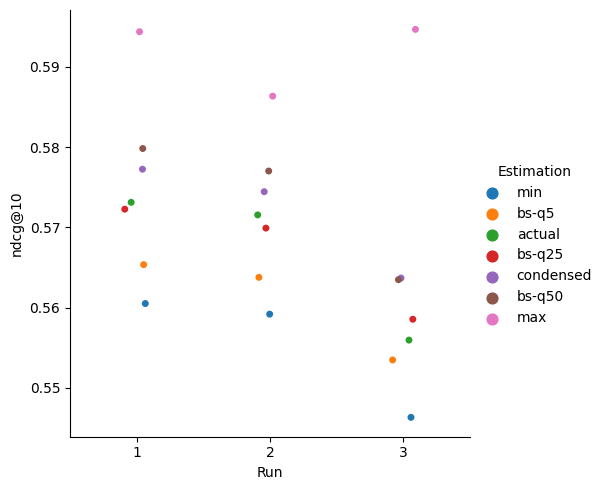

In [83]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] < 4],
    x='Run', y='ndcg@10',
    hue='Estimation',
    hue_order=['min', 'bs-q5', 'actual', 'bs-q25', 'condensed', 'bs-q50', 'max'],
)

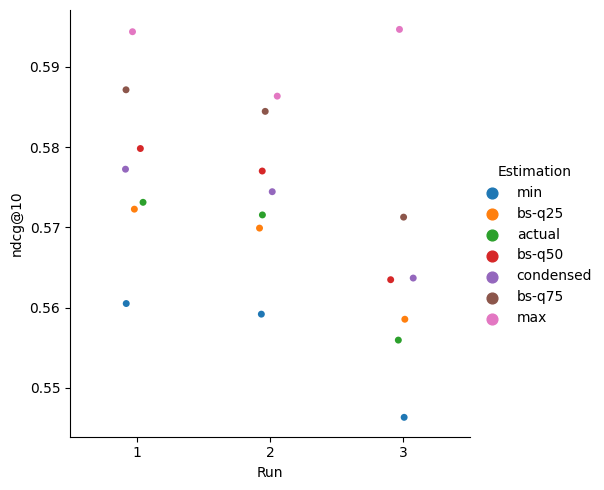

In [74]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] < 4],
    x='Run', y='ndcg@10',
    hue='Estimation',
    hue_order=['min', 'bs-q25', 'actual', 'bs-q50', 'condensed', 'bs-q75', 'max'],
)

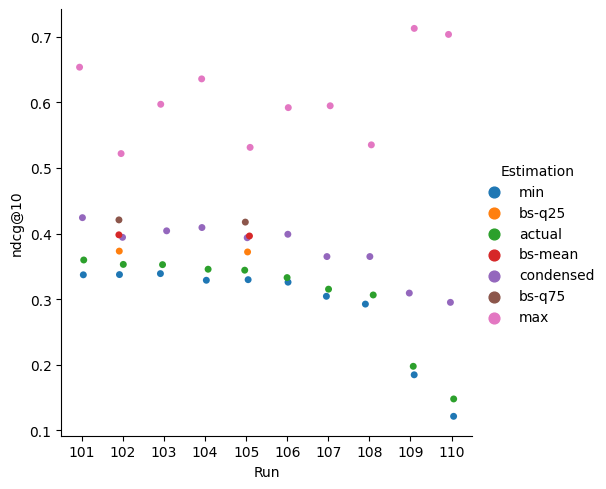

In [69]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] > 100],
    x='Run', y='ndcg@10',
    hue='Estimation',
    hue_order=['min', 'bs-q25', 'actual', 'bs-mean', 'condensed', 'bs-q75', 'max'],
)

# Results for NDCG@10

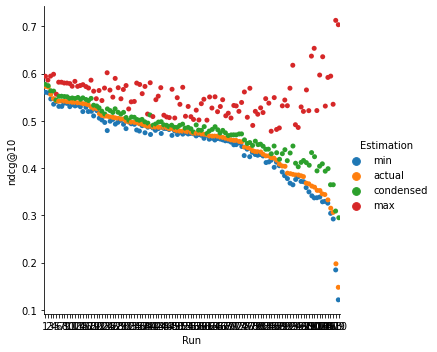

In [9]:
df_for_plot = create_df_for_plot('ndcg', 10)

sns.catplot(
    data=df_for_plot,
    x='Run', y='ndcg@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

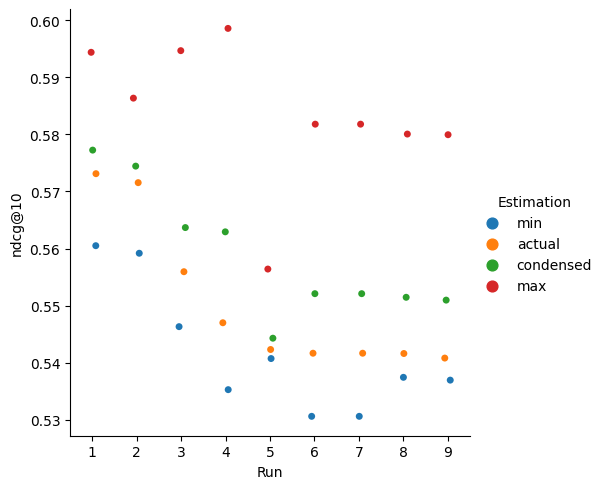

In [11]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] < 10],
    x='Run', y='ndcg@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

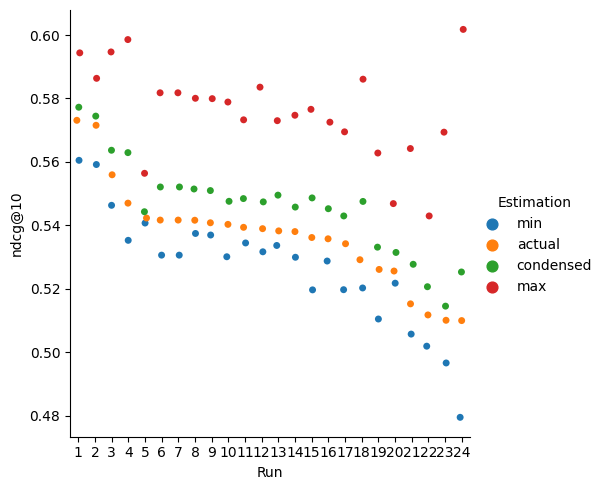

In [12]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] < 25],
    x='Run', y='ndcg@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

# Results for RBP@10

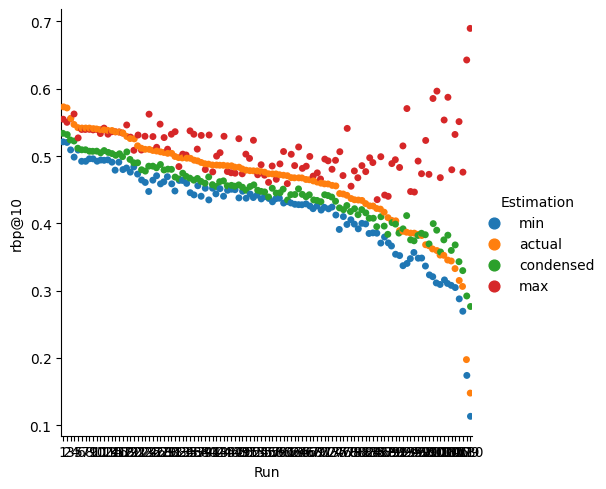

In [14]:
df_for_plot = create_df_for_plot('rbp', 10)

sns.catplot(
    data=df_for_plot,
    x='Run', y='rbp@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

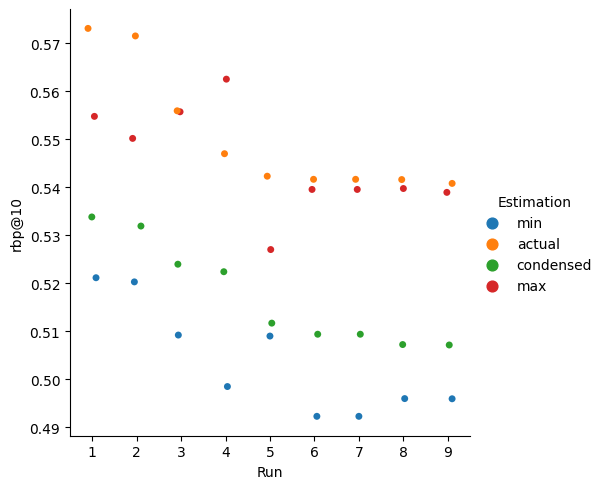

In [15]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] < 10],
    x='Run', y='rbp@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

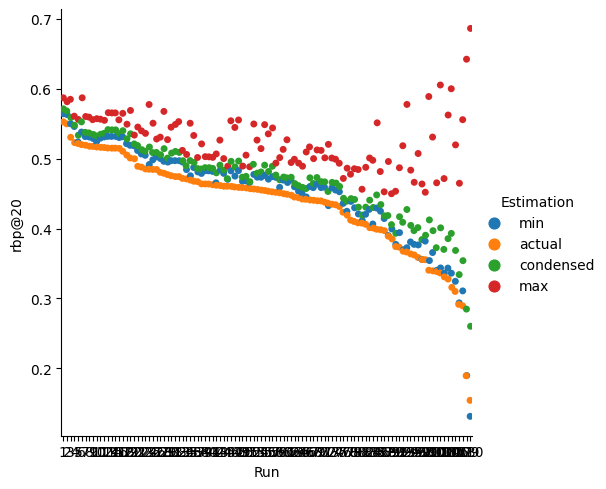

In [17]:
df_for_plot = create_df_for_plot('rbp', 20)

sns.catplot(
    data=df_for_plot,
    x='Run', y='rbp@20',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

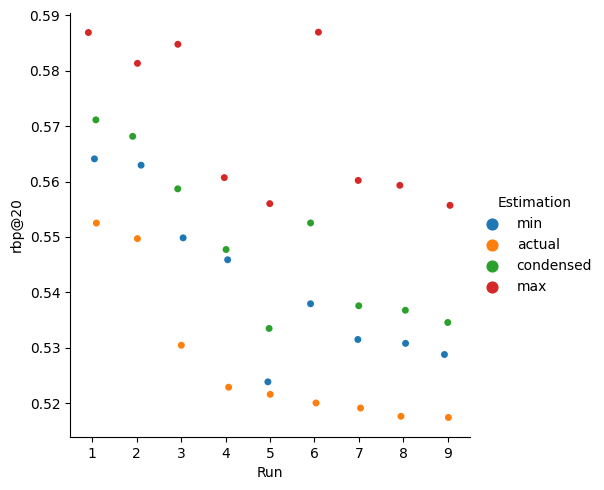

In [18]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] <10],
    x='Run', y='rbp@20',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)